# Transpiler stages

This page describes the stages of Qiskit's prebuilt transpilation pipeline. There are six stages:

1. `init` 
2. `layout`
3. `routing` 
4. `translation`
5. `optimization`
6. `scheduling`

The [`generate_preset_pass_manager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function creates a preset [staged pass manager](/api/qiskit/qiskit.transpiler.StagedPassManager) composed of these stages. The specific passes that make up each stage depends on the arguments passed to `generate_preset_pass_manager`. There is one positional argument that must be specified, the `optimization_level`, which is an integer that can be 0, 1, 2, or 3. Higher values indicate heavier but more costly optimization (see [Transpilation defaults and configuration options](defaults-and-configuration-options)).

The recommended way to transpile a circuit is to create a preset staged pass manager and then run that pass manager on the circuit, as described in [Transpile with pass managers](transpile-with-pass-managers). However, a simpler but less customizable alternative is to use the [`transpile`](/api/qiskit/compiler#qiskit.compiler.transpile) function. This function accepts the circuit directly as an argument. As with `generate_preset_pass_manager`, the specific transpiler passes used depend on the arguments, such as `optimization_level`, passed to `transpile`. In fact, internally the `transpile` function calls `generate_preset_pass_manager` to create a preset staged pass manager and runs it on the circuit.

## Init stage

This first stage does very little by default and is primarily useful if you want to include your own initial optimizations.  Because most layout and routing algorithms are only designed to work with single- and two-qubit gates, this stage is also used to translate any gates that operate on more than two qubits, into gates that only operate on one or two qubits.

For more information about implementing your own initial optimizations for this stage, see the section on plugins and customizing pass managers.

## Layout stage
The next stage involves the layout or connectivity of the backend a circuit will be sent to.  In general, quantum circuits are abstract entities whose qubits are "virtual" or "logical" representations of actual qubits used in computations.  To execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device is necesary.  This mapping is stored as a `Layout` object.


![Qubit mapping](/images/transpile/layout-mapping.png)

The choice of mapping is extremely important for minimizing the number of SWAP operations needed to map the input circuit onto the device topology and ensure the most well-calibrated qubits are used.  Due to the importance of this stage, the preset pass managers try a few different methods to find the best layout.  Typically this involves two steps: first, try to find a "perfect" layout (a layout that does not require any SWAP operations), and then, a heuristic pass that tries to find the best layout to use if a perfect layout cannot be found.  There are two `Passes` typically used for this first step:

- `TrivialLayout`: Naively maps each virtual qubit to the same numbered physical qubit on the device (i.e., [`0`,`1`,`1`,`3`] -> [`0`,`1`,`1`,`3`]).  This is historical behavior only used in `optimzation_level=1` to try to find a perfect layout.  If it fails, `VF2Layout` is tried next.
- `VF2Layout`: This is an `AnalysisPass` that selects an ideal layout by treating this stage as a subgraph isomorphism problem, solved by the VF2++ algorithm.  If more than one layout is found, a scoring heuristic is run to select the mapping with the lowest average error.

Then for the heuristic stage, two passes are used by default:

- `DenseLayout`: Finds the sub-graph of the device with the greatest connectivity and that has the same number of qubits as the circuit  (used for optimization level 1 if there are control flow operations (such as IfElseOp) present in the circuit).
- `SabreLayout`: This pass selects a layout by starting from an initial random layout and repeatedly running the `SabreSwap` algorithm.  This pass is only used in optimization levels 1, 2, and 3 if a perfect layout isn't found via the `VF2Layout` pass.  For more details on this algorithm, refer to the paper [arXiv:1809.02573.](https://arxiv.org/abs/1809.02573)


## Routing stage

In order to implement a two-qubit gate between qubits that are not directly connected on a quantum device, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map.  Each SWAP gate represents an expensive and noisy operation to perform.  Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device is an important step in the transpilation process.  For efficiency, this stage is typically computed alongside the Layout stage by default, but they are logically distinct from one another.  The *Layout* stage selects the hardware qubits to be used, while the *Routing* stage inserts the appropriate amount of SWAP gates in order to execute the circuits using the selected layout.

However, finding the optimal SWAP mapping is hard.  In fact, it is an NP-hard problem, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits.  To work around this, Qiskit uses a stochastic heuristic algorithm called `SabreSwap` to compute a good, but not necessarily optimal, SWAP mapping. The use of a stochastic method means that the circuits generated are not guaranteed to be the same over repeated runs.  Indeed, running the same circuit repeatedly results in a distribution of circuit depths and gate counts at the output.  It is for this reason that many users choose to run the routing function (or the entire `StagedPassManager`) many times and select the lowest-depth circuits from the distribution of outputs.

For example, this is a GHZ circuit executed 100 times, using a “bad” (disconnected) `initial_layout`:
![/images/api/transpiler-11.png](/images/transpile/transpiler-11.png)


Text(0, 0.5, 'Counts')

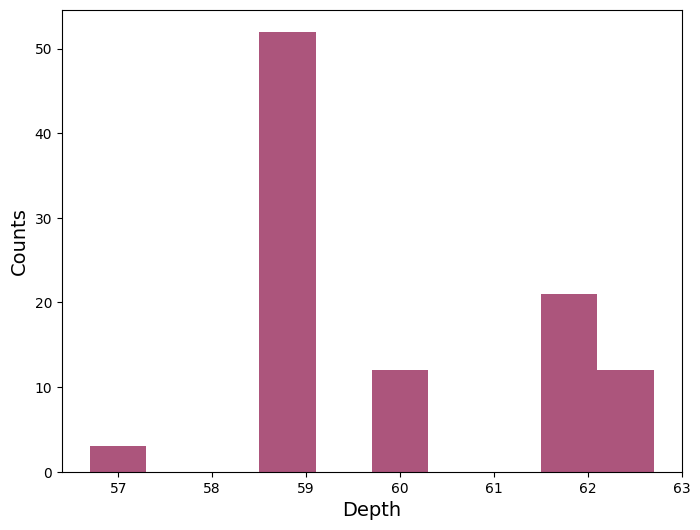

In [1]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeAuckland
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeAuckland()

ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))

pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend,
    layout_method="trivial",  # Fixed layout mapped in circuit order
)
depths = []
for _ in range(100):
    depths.append(pass_manager.run(ghz).depth())

plt.figure(figsize=(8, 6))
plt.hist(depths, align="left", color="#AC557C")
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Counts", fontsize=14)

This distribution is quite wide, signaling the difficulty the SWAP mapper is having in computing the best mapping.

It's also important to point out here that the `SabreSwap` algorithm is different from the larger `SabreLayout` method in the previous stage.  By default, `SabreLayout` runs both layout and routing, and returns the transformed circuit.  This is done for a few particular technical reasons specified in the pass's [API reference page](../api/qiskit/qiskit.transpiler.passes.SabreLayout). 

## Translation stage

When writing a quantum circuit, you are free to use any quantum gate (unitary operation) that you like, along with a collection of non-gate operations such as qubit measurement or reset instructions.  However, most quantum devices only natively support a handful of quantum gate and non-gate operations. This stage of the preset `PassManagers`  translates (or *unrolls*) the gates specified in a circuit to the native basis gates of a specified backend.  This is an important step, as it allows the circuit to be executed by the backend, but typically leads to an increase in the depth and number of gates.

Two special cases are especially important to highlight, and help illustrate what this stage does.

1. If a SWAP gate is not a native gate to the target backend, this requires three CNOT gates:

native gates:['id', 'rz', 'sx', 'x', 'cx', 'reset', 'measure', 'delay']


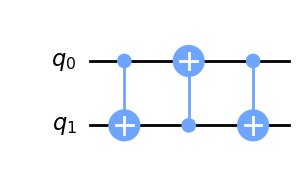

In [2]:
print("native gates:" + str(backend.operation_names))
qc = QuantumCircuit(2)
qc.swap(0, 1)
qc.decompose().draw('mpl')

As a product of three CNOT gates, a SWAP is an expensive operation to perform on noisy quantum devices.  However, such operations are usually necessary for embedding a circuit into the limited gate connectivities of many devices.  Thus, minimizing the number of SWAP gates in a circuit is a primary goal in the transpilation process.

2. A Toffoli, or controlled-controlled-not gate (`ccx`), is a three-qubit gate.  Given that our basis gate set includes only single- and two-qubit gates, this operation must be decomposed.  However, it is quite costly:

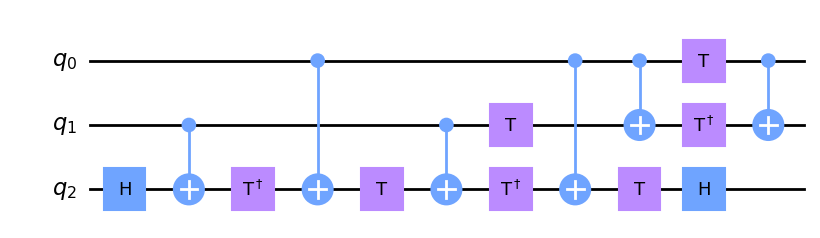

In [3]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.decompose().draw('mpl')

For every Toffoli gate in a quantum circuit, the hardware may execute up to six CNOT gates and a handful of single-qubit gates.  This example demonstrates that any algorithm making use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affected by noise.

## Optimization stage

This stage centers around decomposing quantum circuits into the basis gate set of the target device, and must fight against the increased depth from the layout and routing stages.  Fortunately, there are many routines for optimizing circuits by either combining or eliminating gates.  In some cases, these methods are so effective that the output circuits have lower depth than the inputs, even after layout and routing to the hardware topology.  In other cases, not much can be done, and the computation may be difficult to perform on noisy devices.  This stage is where the various optimization levels begin to differ.

- For `optimization_level=1`, this stage prepares [`Optimize1qGatesDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition) and [`CXCancellation`](../api/qiskit/qiskit.transpiler.passes.CXCancellation), which combine chains of single-qubit gates and cancel any back-to-back CNOT gates.
- For `optimization_level=2`, this stage uses the [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation) pass instead of `CXCancellation`, which removes redundant gates by exploiting commutation relations.
- For `optimization_level=3`, this stage prepares the following passes:
  - [`Collect2qBlocks`](../api/qiskit/qiskit.transpiler.passes.Collect2qBlocks)
  - [`ConsolidateBlocks`](../api/qiskit/qiskit.transpiler.passes.ConsolidateBlocks)
  - [`UnitarySynthesis`](../api/qiskit/qiskit.transpiler.passes.UnitarySynthesis)
  - [`Optimize1qGateDecomposition`](../api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition)
  - [`CommutativeCancellation`](../api/qiskit/qiskit.transpiler.passes.CommutativeCancellation)


Additionally, this stage also executes a few final checks to make sure that all instructions in the circuit are composed of the basis gates available on the target backend.

The example below using a GHZ state demonstrates the effects of different optimization level settings on circuit depth and gate count.

<Admonition type="note">
  The transpilation output varies due to the stochastic SWAP mapper. Therefore, the numbers below will likely change each time you run the code.
</Admonition>

![/images/transpile/transpiler-11.png](/images/transpile/transpiler-11.png)

The following code constructs a 15-qubit GHZ state and compares the `optimization_levels` of transpilation in terms of resulting circuit depth, gate counts, and multi-qubit gate counts.


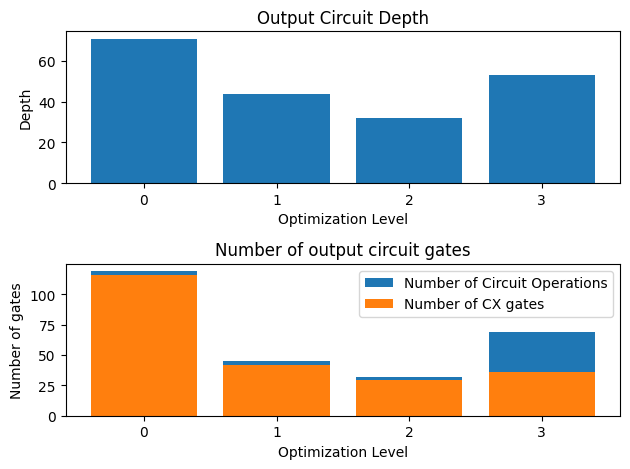

In [4]:
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))

depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=backend,
    )
    circ = pass_manager.run(ghz)
    depths.append(circ.depth())
    gate_counts.append(sum(circ.count_ops().values()))
    multiqubit_gate_counts.append(circ.count_ops()["cx"])

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of CX gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
plt.show()

## Scheduling

This last stage is only run if it is explicitly called for (similar to the Init stage) and does not run by default (though a method can be specified by setting the `scheduling_method` argument when calling `generate_preset_pass_manager`).  The scheduling stage is typically used once the circuit has been translated to the target basis, mapped to the device, and optimized.  These passes focus on accounting for all the idle time in a circuit.  At a high level, the scheduling pass can be thought of as explicitly inserting delay instructions to account for the idle time between gate executions and to inspect how long the circuit will be running on the backend.  

Here is an example:

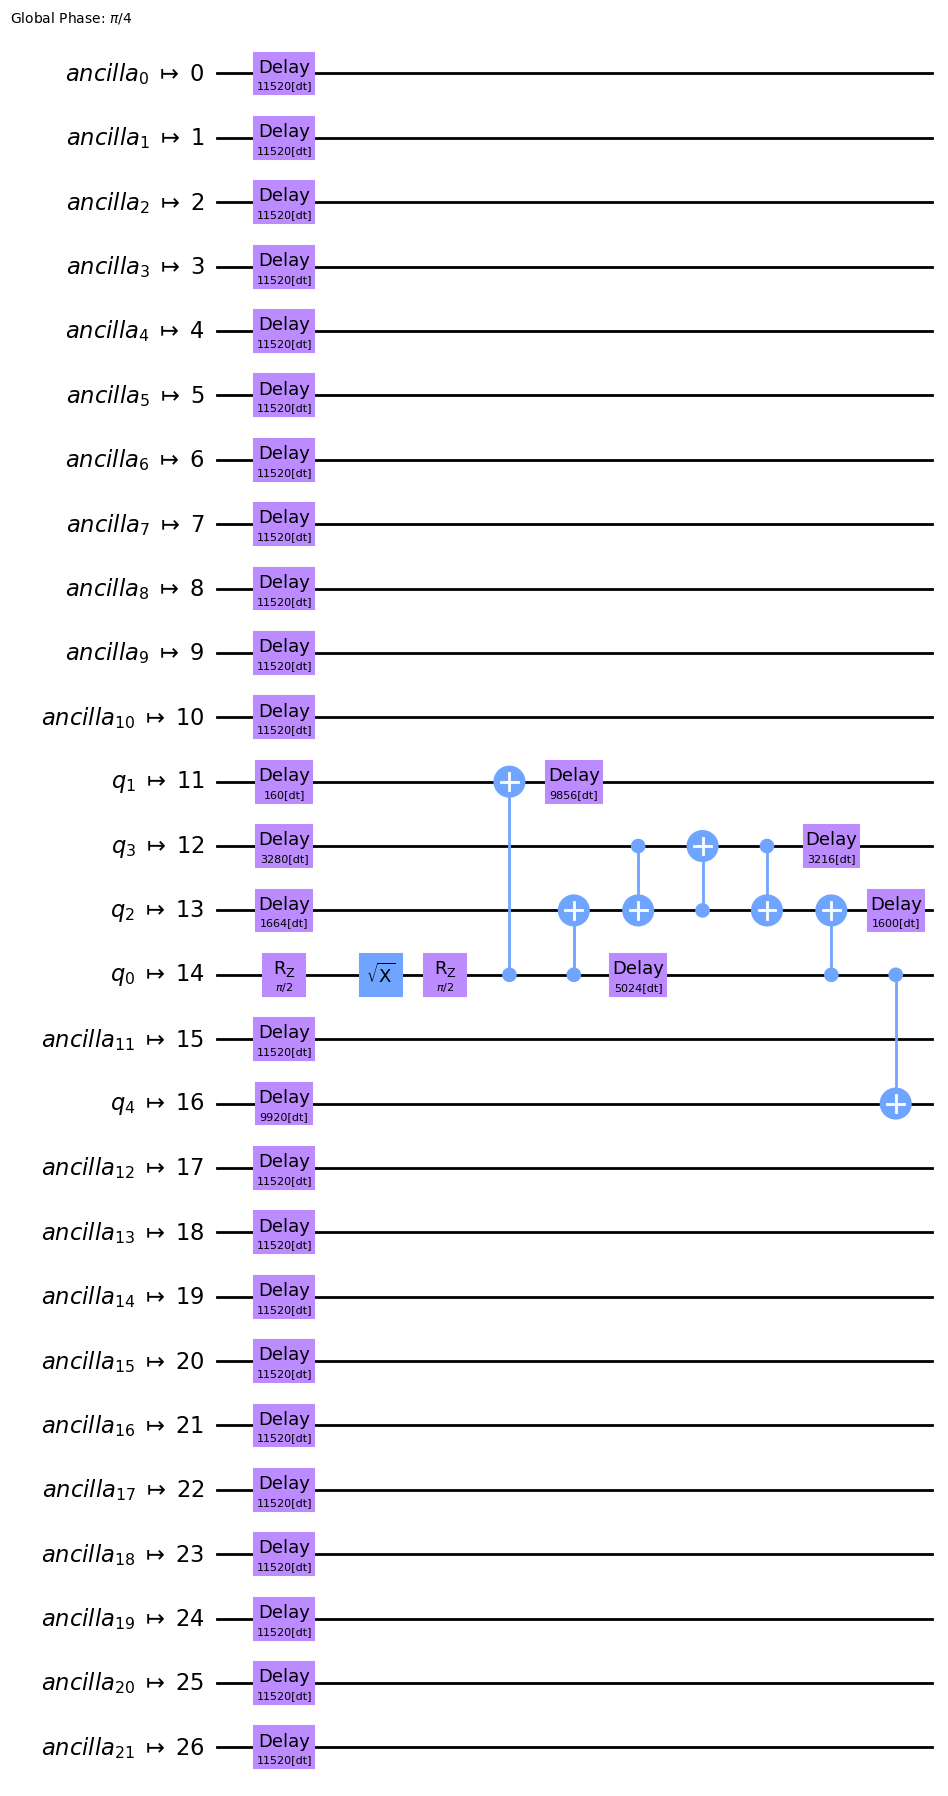

In [5]:
ghz = QuantumCircuit(5)
ghz.h(0)
ghz.cx(0, range(1, 5))

pass_manager = generate_preset_pass_manager(
    optimization_level=level,
    backend=backend,
    scheduling_method="asap"
)
circ = pass_manager.run(ghz, backend)
circ.draw(output="mpl")

![/images/transpile/transpiler-16.png](/images/transpile/transpiler-16.png)

The transpiler inserted `Delay` instructions to account for idle time on each qubit. To get a better idea of the timing of the circuit we can also look at it with the `timeline.draw()` function:

![/images/transpile/transpiler-17.png](/images/transpile/transpiler-17.png)


Scheduling a circuit involves two parts: analysis and constraint mapping, followed by a padding pass.  The first part requires running a scheduling analysis pass (by default this is [`ALAPSchedulingAnalysis`](../api/qiskit/qiskit.transpiler.passes.ALAPScheduleAnalysis)), which analyzes the circuit and records the start time of each instruction in the circuit into a schedule.  Once the circuit has an initial schedule, additional passes can be run to account for any timing constraints on the target backend.  Finally, a padding pass such as [`PadDelay`](../api/qiskit/qiskit.transpiler.passes.PadDelay) or [`PadDynamicalDecoupling`](../api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling) can be executed.

## Next steps

<Admonition type="tip" title="Recommendations">
    - To learn how to use the `transpile` function, start with the [Transpilation default settings and configuration options](defaults-and-configuration-options) topic.
    - Continue learning about transpilation with the [Transpiler with pass managers](transpile-with-pass-managers) topic.
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - See the [Transpile API documentation.](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler)
</Admonition>
